In [10]:
# Reading Libraries 
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import pickle
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

In [11]:
# Function to warp the image 

def warp_image(im):

    im_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

    pixel_colours = im.reshape((im.shape[0]*im.shape[1], 3))
    norm = colors.Normalize(vmin=-1.0,vmax=1.0)
    norm.autoscale(pixel_colours)
    pixel_colours = norm(pixel_colours).tolist()

    # visualise the colours in a RGB colour space
    H, S, V = cv2.split(im_hsv)

    # define lower and upper ranges of HSV to extract blue board 
    lower_hsv = (75,100,10)
    upper_hsv = (105,255,220)

    # Create mask of pixel inside range of lower and upper colours
    mask = cv2.inRange(im_hsv, lower_hsv, upper_hsv) # (Image, lower_bound, upper_bound)

    # Apply mask to visualise
    im_thresh = im.copy()
    im_thresh[(mask==0),:] = (0,0,0)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    im_contours = im.copy()
    cv2.drawContours(im_contours, contours, -1, (0,255,0), 3) # draw using bright green

    arclength = cv2.arcLength(largest_contour, True)
    epsilon = 0.02 * arclength 
    corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    corners = corners.reshape(-1, 2)

    # Order the corners
     # === Order the corner points ===
    ordered_corners = np.zeros((4, 2), dtype="float32")
    corners_sum = corners.sum(axis=1)
    corners_diff = np.diff(corners, axis=1)

    ordered_corners[0] = corners[np.argmin(corners_sum)]      
    ordered_corners[2] = corners[np.argmax(corners_sum)]      
    ordered_corners[1] = corners[np.argmin(corners_diff)]    
    ordered_corners[3] = corners[np.argmax(corners_diff)]    

    h = 300
    w = 400

    corner_points_output = np.float32([
        [0, 0],
        [w - 1, 0],
        [w - 1, h - 1],
        [0, h - 1]
    ])

    M = cv2.getPerspectiveTransform(np.float32(ordered_corners), corner_points_output)
    warped_image = cv2.warpPerspective(im, M, (w,h))


    return warped_image

In [12]:
# Function to determine image state 

def find_game_state(warped_image): 

    warped_hsv = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HSV)

    H1, S1, V1 = cv2.split(warped_hsv)

    pixel_colours = warped_image.reshape((warped_image.shape[0]*warped_image.shape[1], 3))
    norm = colors.Normalize(vmin=-1.0,vmax=1.0)
    norm.autoscale(pixel_colours)
    pixel_colours = norm(pixel_colours).tolist()

    # Red mask
    lower1_red = (175,0,0)
    upper1_red = (200,255,255)

    lower2_red = (0,150,0)
    upper2_red = (10,255,255)

    mask1 = cv2.inRange(warped_hsv, lower1_red, upper1_red)
    mask2 = cv2.inRange(warped_hsv, lower2_red, upper2_red)

    red_mask = cv2.bitwise_or(mask1, mask2)


    # Yellow mask
    lower_yellow = (25,170,100)
    upper_yellow = (35,255,250)

    yellow_mask = cv2.inRange(warped_hsv, lower_yellow, upper_yellow) # (Image, lower_bound, upper_bound)

    # # Apply mask to visualise
    im_red = warped_image.copy()
    im_red[(red_mask==0),:] = (0,0,0)

    im_yellow = warped_image.copy()
    im_yellow[(yellow_mask==0),:] = (0,0,0)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
    red_thresh = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)
    red_thresh = cv2.morphologyEx(red_thresh, cv2.MORPH_CLOSE, kernel)

    #Apply contour to find edges of the board 
    red_contours, _ = cv2.findContours(red_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    im_red_contours = warped_image.copy()
    cv2.drawContours(im_red_contours, red_contours, -1, (0,255,0), 3) # draw using bright green


    yellow_thresh = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel)
    yellow_thresh = cv2.morphologyEx(yellow_thresh, cv2.MORPH_CLOSE, kernel)
    yellow_contours, _ = cv2.findContours(yellow_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    im_yellow_contours = warped_image.copy()
    cv2.drawContours(im_yellow_contours, yellow_contours, -1, (0,255,0), 3) # draw using bright green

    (num_components_red, red_label_img, red_stats, red_centroids) = cv2.connectedComponentsWithStats(red_thresh)

    (num_components_yellow, yellow_label_img, yellow_stats, yellow_centroids) = cv2.connectedComponentsWithStats(yellow_thresh)

    game_state = np.zeros((6, 7))

    row_height = 50 
    col_ranges = [0, 70, 110, 180, 230, 280, 350, 400]

    for i in range(1, num_components_red): 
        cx, cy = red_centroids[i]

        row_num = int(cy // row_height)

        for j in range(len(col_ranges) - 1): 
            if col_ranges[j] <= cx < col_ranges[j+1]:
                col_num = j

        game_state[row_num, col_num] = 2

    for i in range(1, num_components_yellow): 
        cx, cy = yellow_centroids[i]


        row_num = int(cy // row_height)

        for j in range(len(col_ranges) - 1): 
            if col_ranges[j] <= cx < col_ranges[j+1]:
                col_num = j

        game_state[row_num, col_num] = 1


        

    return game_state

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 1. 0. 0.]
 [0. 0. 2. 1. 1. 0. 0.]
 [0. 1. 1. 1. 2. 0. 0.]
 [0. 2. 1. 1. 2. 2. 0.]
 [0. 2. 1. 2. 2. 2. 0.]]


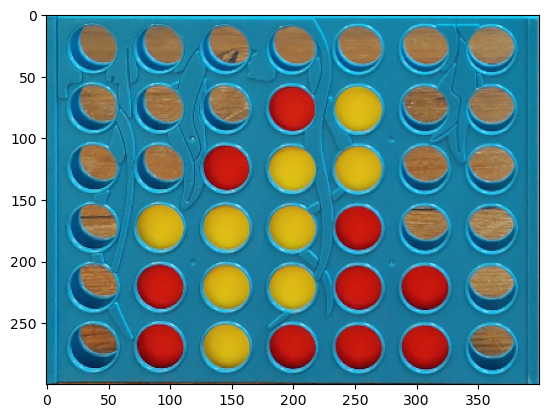

In [28]:
# Finding the game state 

im_01 = cv2.imread('connect_four_images_A1/015.jpg')
im = cv2.cvtColor(im_01, cv2.COLOR_BGR2RGB)

warped_image = warp_image(im)

plt.imshow(warped_image)

game_state = find_game_state(warped_image)

print(game_state)
